# Local Tool Calling Agent

Here, we'll build a [tool calling agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/) using local models.

We'll use the [new fine-tune from Groq](https://wow.groq.com/introducing-llama-3-groq-tool-use-models/) with tool calling via Ollama:

Access the model:

```
ollama pull llama3-groq-tool-use
ollama pull llama3.1
```

And also, we'll use the Ollama partner package.

This notebook accompanies the video here:

https://www.youtube.com/watch?v=Nfk99Fz8H9k

In [4]:
import os

# os.environ["OPENAI_API_KEY"] = "sk-xxx"

# os.environ["TAVILY_API_KEY"] = "tvly-xxx"

In [5]:
!pip install -qU langchain-ollama langchain-openai
!pip install scikit-learn

  Using cached scikit_learn-1.5.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (12 kB)
  Using cached scipy-1.14.0-cp311-cp311-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-macosx_12_0_arm64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.0-cp311-cp311-macosx_14_0_arm64.whl (23.1 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [1]:
# /// LLM ///

from langchain_ollama import ChatOllama

llm = ChatOllama(
    # model="llama3-groq-tool-use",
    model="llama3.1",
    temperature=0,
)

In [2]:
def retrieve_guest_number(guest_name: str) -> int:
    """Given a guest name this function returns the guest number."""
    return ["Alice", "Bob", "Charlie", "David"].index(guest_name) + 1


tools = [retrieve_guest_number]

llm_with_tools = llm.bind_tools(tools)

llm_with_tools.invoke("Use your tools to figure out the guest number of Bob.")

AIMessage(content='', response_metadata={'model': 'llama3.1', 'created_at': '2024-08-08T14:50:36.77604Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'retrieve_guest_number', 'arguments': {'guest_name': 'Bob'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 733001916, 'load_duration': 25315208, 'prompt_eval_count': 162, 'prompt_eval_duration': 391709000, 'eval_count': 19, 'eval_duration': 313938000}, id='run-a7d2e44d-06fb-4b52-bac2-30ef403ef70b-0', tool_calls=[{'name': 'retrieve_guest_number', 'args': {'guest_name': 'Bob'}, 'id': 'a28ee7b6-62c8-4b04-9c11-37aba4b81ee4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 19, 'total_tokens': 181})

In [4]:
# /// Retriever tool ///

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using OpenAIEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)


# Define a tool, which we will connect to our agent
def retrieve_documents(query: str) -> list:
    """Retrieve documents from the vector store based on the query."""
    return retriever.invoke(query)


# /// Search Tool

from langchain_community.tools.tavily_search import TavilySearchResults

from langchain.schema import Document

web_search_tool = TavilySearchResults()


def web_search(query: str) -> str:
    """Run web search on the question."""
    web_results = web_search_tool.invoke({"query": query})
    return [
        Document(page_content=d["content"], metadata={"url": d["url"]})
        for d in web_results
    ]

# Tool list
tools = [retrieve_documents, web_search]

In [5]:
llm = ChatOllama(model="llama3.1", temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [6]:
llm_with_tools.invoke("Use your search tool to search the web for the funniest jokes about cat people.")

AIMessage(content='', response_metadata={'model': 'llama3.1', 'created_at': '2024-08-08T14:51:48.566236Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'web_search', 'arguments': {'query': 'funniest jokes about cat people'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 740909834, 'load_duration': 22674084, 'prompt_eval_count': 207, 'prompt_eval_duration': 354731000, 'eval_count': 22, 'eval_duration': 362201000}, id='run-24572cb5-5d6a-4f27-8885-e4bacd3af368-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'funniest jokes about cat people'}, 'id': '92c24c4b-7d9a-4f2b-8a6e-e42e1db47dfa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 207, 'output_tokens': 22, 'total_tokens': 229})

In [7]:
from typing import Annotated, List

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant tasked with answering user questions. "
            "You have access to two tools: retrieve_documents and web_search. "
            "For any user questions about LLM agents, use the retrieve_documents tool to get information for a vectorstore. "
            "For any other questions, such as questions about current events, use the web_search tool to get information from the web. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

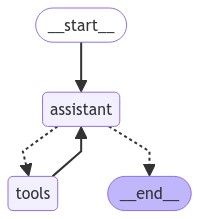

In [12]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


from IPython.display import Image, display
# from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# memory = SqliteSaver.from_conn_string(":memory:")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
import uuid

def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation"""

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    messages = react_graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages["messages"][-1].content, "messages": messages}


example = {"input": "Get me information about the the types of LLM agent memory?"}
response = predict_react_agent_answer(example)

See trace with llama3.1 here:

https://smith.langchain.com/public/44d0c7dd-a756-47ad-8025-ee7ae6469ecb/r

In [14]:
example = {"input": "Get me information about the current weather in SF."}
response = predict_react_agent_answer(example)

See trace with llama3.1 here:

https://smith.langchain.com/public/7a4938e3-f94f-4e04-a162-bf592fba4643/r

In [15]:
response

{'response': 'The current weather in SF is partly cloudy with a temperature of 13.5°C (56.3°F). There is no precipitation and the humidity is at 88%. The wind speed is 9.4 km/h (5.8 mph) from the WSW direction.',
 'messages': {'messages': [HumanMessage(content='Get me information about the current weather in SF.', id='16def55f-4c02-4829-bdf1-57f35e3262d9'),
   AIMessage(content='', response_metadata={'model': 'llama3.1', 'created_at': '2024-08-08T14:54:30.58967Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'web_search', 'arguments': {'query': 'current weather in San Francisco'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 587123834, 'load_duration': 10742375, 'prompt_eval_count': 271, 'prompt_eval_duration': 222817000, 'eval_count': 21, 'eval_duration': 351873000}, id='run-22d367ed-da54-479f-96d2-bab30e896e3e-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'current weather in San Francisco'}, 'id': 'bf0c33e3-9d7b-4fad-95